<a href="https://colab.research.google.com/github/2024-MJU-Capstone-Design/coinmerge-ml/blob/feature%2Fverify-ml/Bitcoin_Price_Prediction_tomorrow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyupbit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 1.7 MB/s eta 0:00:00


Epoch 1/100
19/19 [==============================] - 4s 56ms/step - loss: 853360945135616.0000 - val_loss: 713203411582976.0000
Epoch 2/100
19/19 [==============================] - 0s 16ms/step - loss: 853360609591296.0000 - val_loss: 713203277365248.0000
Epoch 3/100
19/19 [==============================] - 0s 13ms/step - loss: 853360408264704.0000 - val_loss: 713203277365248.0000
Epoch 4/100
19/19 [==============================] - 0s 13ms/step - loss: 853360408264704.0000 - val_loss: 713203143147520.0000
Epoch 5/100
19/19 [==============================] - 0s 13ms/step - loss: 853360408264704.0000 - val_loss: 713203143147520.0000
Epoch 6/100
19/19 [==============================] - 0s 12ms/step - loss: 853360341155840.0000 - val_loss: 713203143147520.0000
Epoch 7/100
19/19 [==============================] - 0s 13ms/step - loss: 853360274046976.0000 - val_loss: 713202941820928.0000
Epoch 8/100
19/19 [==============================] - 0s 16ms/step - loss: 853360206938112.0000 - val_los

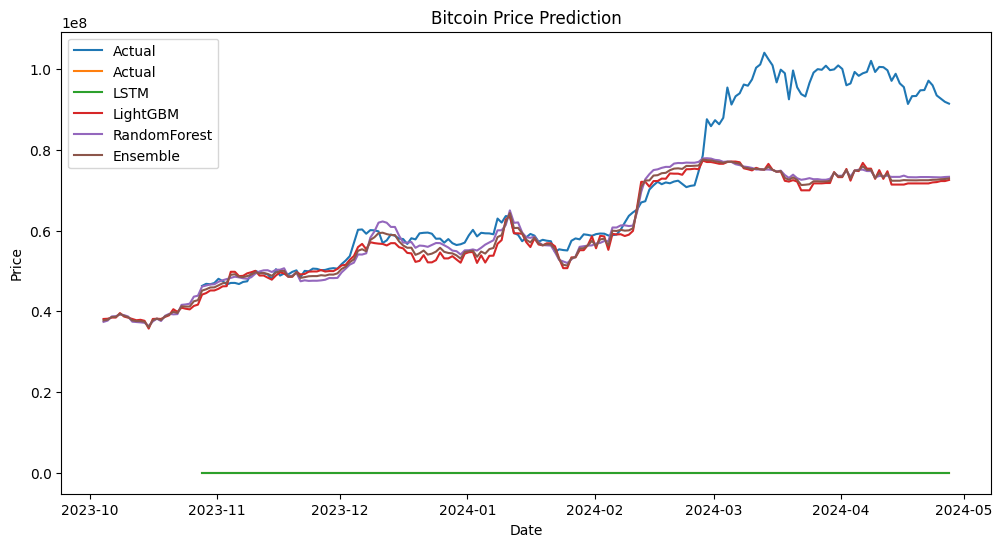

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import pyupbit
from sklearn.ensemble import RandomForestRegressor

# 데이터 로드
df = pyupbit.get_ohlcv("KRW-BTC", count=365*3)  # 3년치 데이터 로드

# 데이터 전처리
df['MA7'] = df['close'].rolling(window=7).mean()
df['MA14'] = df['close'].rolling(window=14).mean()
df['MA30'] = df['close'].rolling(window=30).mean()
df['MA50'] = df['close'].rolling(window=50).mean()
df['Volatility'] = df['close'].rolling(window=30).std()
df['VMA14'] = df['volume'].rolling(window=14).mean()
df['VMA50'] = df['volume'].rolling(window=50).mean()
df.dropna(inplace=True)

def calculate_rsi(data, window=14):
    delta = data['close'].diff()
    gains, declines = delta.copy(), delta.copy()
    gains[gains < 0] = 0
    declines[declines > 0] = 0
    avg_gains = gains.rolling(window=window).mean()
    avg_declines = -declines.rolling(window=window).mean()
    rs = avg_gains / avg_declines
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_rsi(df)
df['Target'] = df['close'].shift(-1)  # 다음 날 종가를 Target으로 설정
df.dropna(inplace=True)

# LSTM 입력 데이터 생성
def create_lstm_data(data, look_back=120):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

X_lstm, Y_lstm = create_lstm_data(df[['close', 'RSI']].values)

# LightGBM 입력 데이터 생성
X_lgb = df[['MA7', 'MA14', 'MA30', 'MA50', 'VMA14', 'VMA50', 'Volatility', 'RSI']]
Y_lgb = df['Target']

# 학습/테스트 데이터 분할
test_size = 0.2
X_train_lstm, X_test_lstm, Y_train_lstm, Y_test_lstm = train_test_split(X_lstm, Y_lstm, test_size=test_size, shuffle=False)
X_train_lgb, X_test_lgb, Y_train_lgb, Y_test_lgb = train_test_split(X_lgb, Y_lgb, test_size=test_size, shuffle=False)

# 정규화 적용
scaler = MinMaxScaler()
X_train_lstm_scaled = scaler.fit_transform(X_train_lstm.reshape(-1, X_train_lstm.shape[-1])).reshape(X_train_lstm.shape)
X_test_lstm_scaled = scaler.transform(X_test_lstm.reshape(-1, X_test_lstm.shape[-1])).reshape(X_test_lstm.shape)

# LSTM 모델 구축 및 학습
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(120, 2)),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train_lstm_scaled, Y_train_lstm, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])

# LightGBM 하이퍼파라미터 튜닝
param_grid = {
    'num_leaves': [31, 63, 127],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

lgb_model = lgb.LGBMRegressor(random_state=42)
kf = KFold(n_splits=5)
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_lgb, Y_train_lgb)

best_params = grid_search.best_params_
lgb_model = lgb.LGBMRegressor(**best_params)

# LightGBM 교차 검증을 통한 모델 평가
cv_scores = []
for train_index, val_index in kf.split(X_lgb):
    X_train, X_val = X_lgb.iloc[train_index], X_lgb.iloc[val_index]
    Y_train, Y_val = Y_lgb.iloc[train_index], Y_lgb.iloc[val_index]

    lgb_model.fit(X_train, Y_train)
    val_pred = lgb_model.predict(X_val)
    cv_scores.append(mean_squared_error(Y_val, val_pred, squared=False))

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")

# LightGBM 모델 학습
lgb_model.fit(X_train_lgb, Y_train_lgb)

# 예측
lstm_pred = lstm_model.predict(X_test_lstm_scaled)

# 스케일러를 lstm_pred의 shape에 맞게 다시 fitting
scaler_lstm = MinMaxScaler()
scaler_lstm.fit(lstm_pred)

lstm_pred = scaler_lstm.inverse_transform(lstm_pred)

lgb_pred = lgb_model.predict(X_test_lgb)

# 앙상블
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_lgb, Y_train_lgb)
rf_pred = rf_model.predict(X_test_lgb)
ensemble_pred = (lgb_pred + rf_pred) / 2

# 평가
mae_lstm = mean_absolute_error(Y_test_lstm[:, 0], lstm_pred.flatten())
mae_lgb = mean_absolute_error(Y_test_lgb, lgb_pred)
mae_rf = mean_absolute_error(Y_test_lgb, rf_pred)
mae_ensemble = mean_absolute_error(Y_test_lgb, ensemble_pred)

print(f"LSTM MAE: {mae_lstm:.2f}")
print(f"LightGBM MAE: {mae_lgb:.2f}")
print(f"RandomForest MAE: {mae_rf:.2f}")
print(f"Ensemble MAE: {mae_ensemble:.2f}")

# 그래프 생성
plt.figure(figsize=(12, 6))

# 실제 데이터 플롯
plt.plot(df.index[-len(Y_test_lstm):], Y_test_lstm, label='Actual')

# LSTM 예측 결과 플롯
plt.plot(df.index[-len(lstm_pred):], lstm_pred, label='LSTM')

# LightGBM 예측 결과 플롯
plt.plot(df.index[-len(lgb_pred):], lgb_pred, label='LightGBM')

# RandomForest 예측 결과 플롯
plt.plot(df.index[-len(rf_pred):], rf_pred, label='RandomForest')

# 앙상블 예측 결과 플롯
plt.plot(df.index[-len(ensemble_pred):], ensemble_pred, label='Ensemble')

# 그래프 제목 및 축 레이블 설정
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')

# 범례 표시
plt.legend()

# 그래프 표시
plt.show()